In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-kymogram/final kymograms cropped/functional/552_crop6.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/267_crop16.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/50_crop12.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/405_crop11.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/598_crop9.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/435_crop2.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/435_crop14.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/373_crop8.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/175_crop13.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/107_crop6.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/72_crop15.png
/kaggle/input/final-kymogram/final kymograms cropped/functional/173_crop34.png
/kaggle/input/final-kymogram/final kymograms cropped/functi

In [2]:
from sklearn.model_selection import train_test_split
import os, shutil
from pathlib import Path
from collections import defaultdict

src_dir = Path("/kaggle/input/final-kymogram/final kymograms cropped")
dst_dir = Path("/kaggle/working/tertiary_split")

# Step 1: Gather all images with their class labels
all_images = []
class_map = defaultdict(list)

for cls in os.listdir(src_dir):
    cls_dir = src_dir / cls
    images = list(cls_dir.glob("*.png"))
    for img in images:
        all_images.append((img, cls))  # Store path and class label
        class_map[cls].append(img)

# Step 2: Global split - 15% test
trainval, test = train_test_split(all_images, test_size=0.15, random_state=42, stratify=[label for _, label in all_images])

# Step 3: Split remaining into 70% train, 30% val
train, val = train_test_split(trainval, test_size=0.15, random_state=42, stratify=[label for _, label in trainval])

# Step 4: Copy images to appropriate folders
def copy_images(split_name, data):
    for img_path, cls in data:
        split_dir = dst_dir / split_name / cls
        split_dir.mkdir(parents=True, exist_ok=True)
        shutil.copy(img_path, split_dir / img_path.name)

copy_images("train", train)
copy_images("val", val)
copy_images("test", test)

In [3]:
import random
import shutil
from pathlib import Path

train_dir = Path("/kaggle/working/tertiary_split/train")

# Step 1: Count images in each class
class_counts = {}
for cls_folder in train_dir.iterdir():
    if cls_folder.is_dir():
        class_counts[cls_folder.name] = len(list(cls_folder.glob("*.png")))

# Step 2: Find maximum class count
max_count = max(class_counts.values())

# Step 3: Oversample each class to match max_count
for cls_name, count in class_counts.items():
    cls_path = train_dir / cls_name
    images = list(cls_path.glob("*.png"))
    
    if count < max_count:
        needed = max_count - count
        to_duplicate = random.choices(images, k=needed)  # Randomly pick with replacement

        for i, img in enumerate(to_duplicate):
            # Create new filename to avoid overwriting
            new_name = cls_path / f"{img.stem}_dup{i}{img.suffix}"
            shutil.copy(img, new_name)

print(" Training set balanced by oversampling.")

 Training set balanced by oversampling.


In [4]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
from pathlib import Path

# Define base path
base_path = Path("/kaggle/working/tertiary_split")

# Transform for ResNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load pretrained ResNet-152
resnet = models.resnet152(pretrained=True)
resnet.fc = torch.nn.Identity()  # Remove classifier
resnet.eval()

# Function to extract features
def extract_features(data_path, save_prefix):
    dataset = datasets.ImageFolder(root=data_path, transform=transform)
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []

    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc=f"Extracting from {save_prefix}"):
            output = resnet(inputs)
            features.append(output)
            labels.append(targets)

    features = torch.cat(features).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()

    np.save(f"/kaggle/working/{save_prefix}_features.npy", features)
    np.save(f"/kaggle/working/{save_prefix}_labels.npy", labels)

# Extract for train, val, and test
extract_features(base_path / "train", "train")
extract_features(base_path / "val", "val")
extract_features(base_path / "test", "test")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 207MB/s]  
Extracting from test: 100%|██████████| 47/47 [04:40<00:00,  5.96s/it]


In [10]:
import torch.nn as nn

class AlexNetFeatureClassifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=3):
        super(AlexNetFeatureClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)


Epoch 1/30, Train Loss: 0.8257, Train Acc: 59.66%, Val Loss: 0.6045, Val Acc: 74.80%
Epoch 2/30, Train Loss: 0.4615, Train Acc: 80.34%, Val Loss: 0.4565, Val Acc: 79.48%
Epoch 3/30, Train Loss: 0.2693, Train Acc: 89.38%, Val Loss: 0.2517, Val Acc: 90.10%
Epoch 4/30, Train Loss: 0.1650, Train Acc: 94.01%, Val Loss: 0.1328, Val Acc: 95.56%
Epoch 5/30, Train Loss: 0.1058, Train Acc: 96.45%, Val Loss: 0.0988, Val Acc: 96.99%
Epoch 6/30, Train Loss: 0.0965, Train Acc: 96.45%, Val Loss: 0.0980, Val Acc: 96.83%
Epoch 7/30, Train Loss: 0.0715, Train Acc: 97.56%, Val Loss: 0.1147, Val Acc: 96.12%
Epoch 8/30, Train Loss: 0.0563, Train Acc: 97.92%, Val Loss: 0.0711, Val Acc: 97.70%
Epoch 9/30, Train Loss: 0.0551, Train Acc: 97.95%, Val Loss: 0.0536, Val Acc: 98.26%
Epoch 10/30, Train Loss: 0.0540, Train Acc: 98.16%, Val Loss: 0.0625, Val Acc: 98.02%
Epoch 11/30, Train Loss: 0.0445, Train Acc: 98.50%, Val Loss: 0.0592, Val Acc: 98.34%
Epoch 12/30, Train Loss: 0.0417, Train Acc: 98.55%, Val Loss: 0

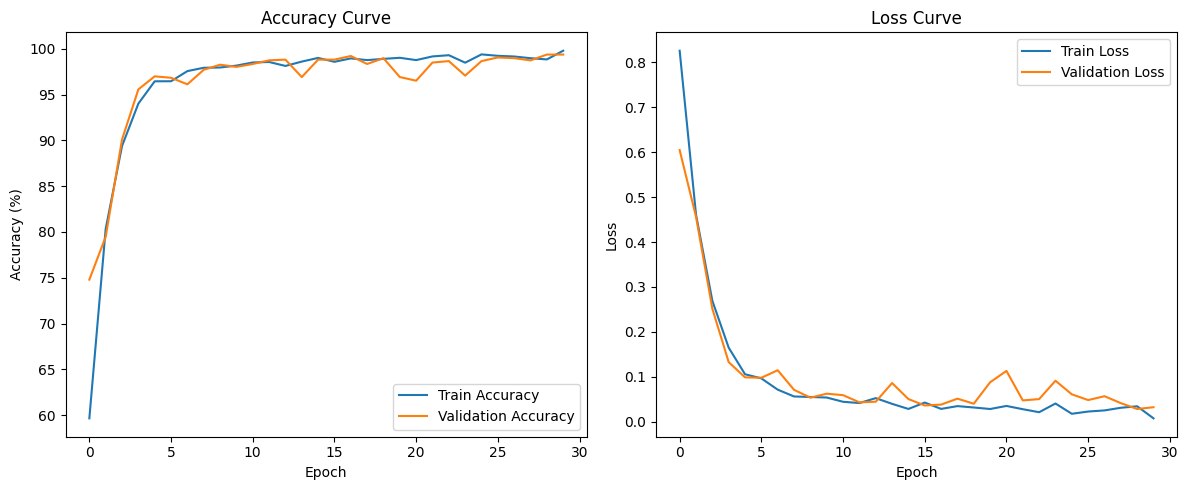


Classification Report:
              precision    recall  f1-score   support

           0     0.9968    0.9810    0.9888       316
           1     0.9957    0.9936    0.9946       933
           2     0.9712    1.0000    0.9854       236

    accuracy                         0.9919      1485
   macro avg     0.9879    0.9915    0.9896      1485
weighted avg     0.9920    0.9919    0.9919      1485



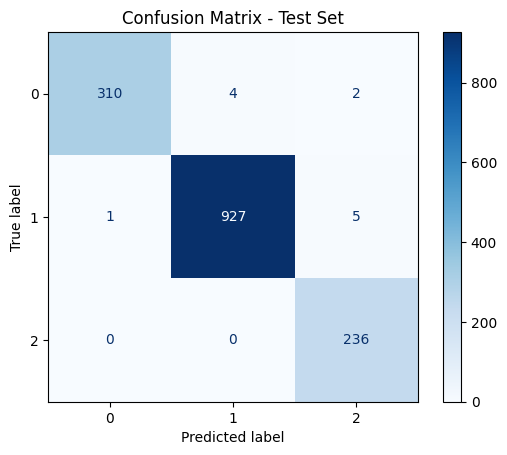

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# AlexNet-style Classifier for 3 Classes
class AlexNetFeatureClassifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=3):
        super(AlexNetFeatureClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

# Load features and labels
X_train = torch.tensor(np.load("/kaggle/working/train_features.npy"), dtype=torch.float32)
y_train = torch.tensor(np.load("/kaggle/working/train_labels.npy"), dtype=torch.long)

X_val = torch.tensor(np.load("/kaggle/working/val_features.npy"), dtype=torch.float32)
y_val = torch.tensor(np.load("/kaggle/working/val_labels.npy"), dtype=torch.long)

X_test = torch.tensor(np.load("/kaggle/working/test_features.npy"), dtype=torch.float32)
y_test = torch.tensor(np.load("/kaggle/working/test_labels.npy"), dtype=torch.long)

# Dataloaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNetFeatureClassifier(input_dim=2048, num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Tracking history
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# Training loop
epochs = 30
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = output.max(1)
        correct_train += (predicted == batch_y).sum().item()
        total_train += batch_y.size(0)

    train_acc = correct_train / total_train * 100
    history['train_loss'].append(total_loss / len(train_loader))
    history['train_acc'].append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x, val_y = val_x.to(device), val_y.to(device)
            val_output = model(val_x)
            val_loss += criterion(val_output, val_y).item()
            _, predicted = val_output.max(1)
            correct_val += (predicted == val_y).sum().item()
            total_val += val_y.size(0)

    val_acc = correct_val / total_val * 100
    history['val_loss'].append(val_loss / len(val_loader))
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, "
          f"Train Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy Curve
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

# Loss Curve
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.tight_layout()
plt.show()

# =======================
# Evaluation on Test Set
# =======================
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device)
        outputs = model(test_x)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(test_y.numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(all_true, all_preds, digits=4))

# Confusion Matrix
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.show()



Validation Performance of AlexNet Classification
Metrics             AlexNet
------------------------------
healthy
AUC (%)              100.00
F1 score (%)          99.44
Precision (%)        100.00
Recall (%)            98.88
Sensitivity (%)       98.88
Specificity (%)      100.00
------------------------------
functional
AUC (%)               99.87
F1 score (%)          99.49
Precision (%)         99.62
Recall (%)            99.37
Sensitivity (%)       99.37
Specificity (%)       99.36
------------------------------
organic
AUC (%)               99.94
F1 score (%)          98.77
Precision (%)         97.57
Recall (%)           100.00
Sensitivity (%)      100.00
Specificity (%)       99.53
------------------------------
Overall Accuracy (%)99.37


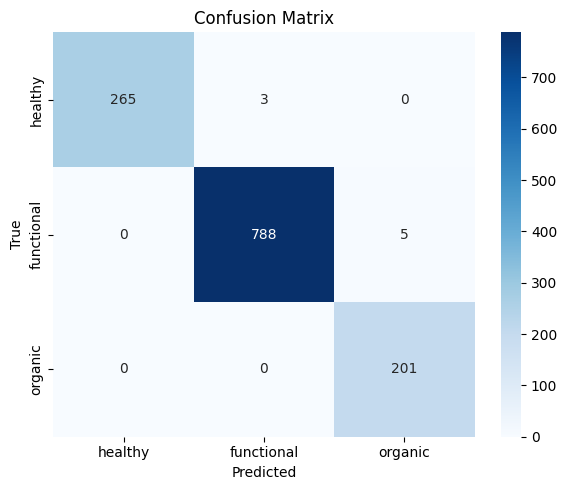

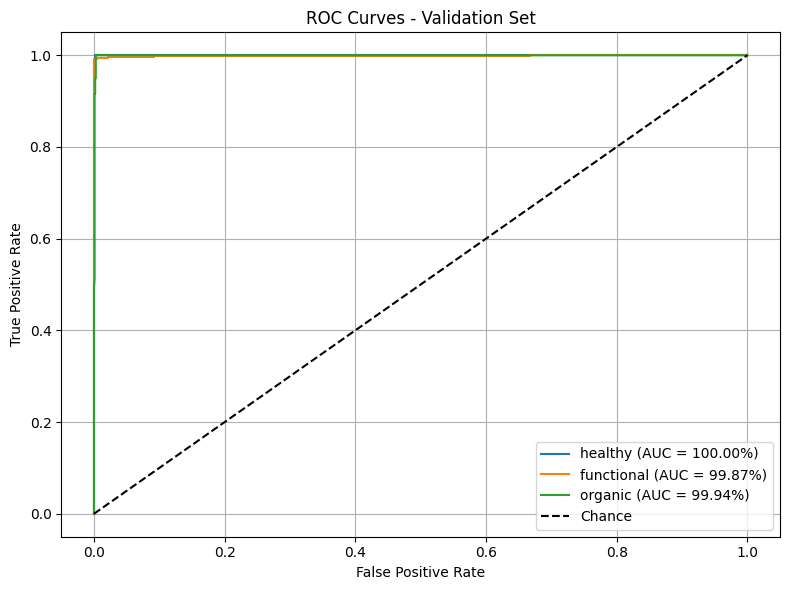

In [7]:
import torch
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    roc_curve
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

# Set model to evaluation mode
model.eval()

# Initialize containers
y_true = []
y_pred = []
y_pred_probs = []

# Disable gradient tracking
with torch.no_grad():
    for val_x, val_y in val_loader:
        val_x = val_x.to(device)
        val_y = val_y.to(device)

        outputs = model(val_x)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        y_true.extend(val_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_probs.append(probs.cpu())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = torch.cat(y_pred_probs, dim=0).numpy()

# Class names
class_names = ["healthy", "functional", "organic"]

# Classification Report and Confusion Matrix
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred)

# Binarize true labels for AUC and ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# AUC Scores
auc_scores = roc_auc_score(y_true_bin, y_pred_probs, average=None)

# Sensitivity & Specificity
sensitivity = []
specificity = []

for i in range(len(class_names)):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    sensitivity.append(TP / (TP + FN) * 100 if (TP + FN) > 0 else 0)
    specificity.append(TN / (TN + FP) * 100 if (TN + FP) > 0 else 0)

# Overall Accuracy
acc = accuracy_score(y_true, y_pred) * 100

# Print Report
print("\nValidation Performance of AlexNet Classification")
print(f"{'Metrics':<15}{'AlexNet':>12}")
print("-" * 30)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'AUC (%)':<15}{auc_scores[i] * 100:>12.2f}")
    print(f"{'F1 score (%)':<15}{report[cls]['f1-score'] * 100:>12.2f}")
    print(f"{'Precision (%)':<15}{report[cls]['precision'] * 100:>12.2f}")
    print(f"{'Recall (%)':<15}{report[cls]['recall'] * 100:>12.2f}")
    print(f"{'Sensitivity (%)':<15}{sensitivity[i]:>12.2f}")
    print(f"{'Specificity (%)':<15}{specificity[i]:>12.2f}")
    print("-" * 30)

print(f"{'Overall Accuracy (%)':<20}{acc:.2f}")

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curves per class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_scores[i]*100:.2f}%)')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title("ROC Curves - Validation Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()



Test Performance of AlexNet Classification
Metrics             AlexNet
------------------------------
healthy
AUC (%)               99.95
F1 score (%)          98.73
Precision (%)         98.73
Recall (%)            98.73
Sensitivity (%)       98.73
Specificity (%)       99.66
------------------------------
functional
AUC (%)               99.95
F1 score (%)          99.46
Precision (%)         99.89
Recall (%)            99.04
Sensitivity (%)       99.04
Specificity (%)       99.82
------------------------------
organic
AUC (%)              100.00
F1 score (%)          98.33
Precision (%)         96.72
Recall (%)           100.00
Sensitivity (%)      100.00
Specificity (%)       99.36
------------------------------
Overall Accuracy (%)99.12


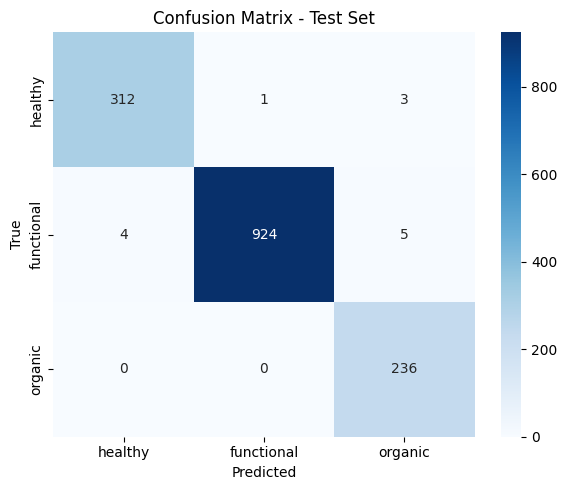

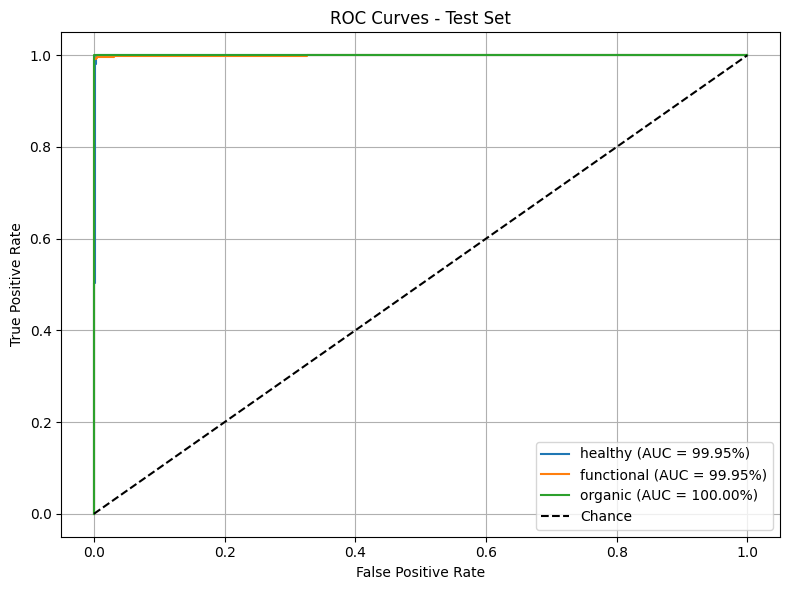

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import label_binarize

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)

# Set model to evaluation mode
model.eval()

# Initialize containers
y_true_test = []
y_pred_test = []
y_pred_probs_test = []

# Disable gradient tracking
with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device)
        test_y = test_y.to(device)

        outputs = model(test_x)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)

        y_true_test.extend(test_y.cpu().numpy())
        y_pred_test.extend(preds.cpu().numpy())
        y_pred_probs_test.append(probs.cpu())

# Convert to numpy arrays
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
y_pred_probs_test = torch.cat(y_pred_probs_test, dim=0).numpy()

# Class names
class_names = ["healthy", "functional", "organic"]

# Classification Report and Confusion Matrix
report_test = classification_report(y_true_test, y_pred_test, target_names=class_names, output_dict=True)
conf_matrix_test = confusion_matrix(y_true_test, y_pred_test)

# Binarize true labels for AUC and ROC
y_true_bin_test = label_binarize(y_true_test, classes=[0, 1, 2])

# AUC Scores
auc_scores_test = roc_auc_score(y_true_bin_test, y_pred_probs_test, average=None)

# Sensitivity & Specificity
sensitivity_test = []
specificity_test = []

for i in range(len(class_names)):
    TP = conf_matrix_test[i, i]
    FN = conf_matrix_test[i].sum() - TP
    FP = conf_matrix_test[:, i].sum() - TP
    TN = conf_matrix_test.sum() - (TP + FP + FN)

    sensitivity_test.append(TP / (TP + FN) * 100 if (TP + FN) > 0 else 0)
    specificity_test.append(TN / (TN + FP) * 100 if (TN + FP) > 0 else 0)

# Overall Accuracy
acc_test = accuracy_score(y_true_test, y_pred_test) * 100

# Print Report
print("\nTest Performance of AlexNet Classification")
print(f"{'Metrics':<15}{'AlexNet':>12}")
print("-" * 30)

for i, cls in enumerate(class_names):
    print(cls)
    print(f"{'AUC (%)':<15}{auc_scores_test[i] * 100:>12.2f}")
    print(f"{'F1 score (%)':<15}{report_test[cls]['f1-score'] * 100:>12.2f}")
    print(f"{'Precision (%)':<15}{report_test[cls]['precision'] * 100:>12.2f}")
    print(f"{'Recall (%)':<15}{report_test[cls]['recall'] * 100:>12.2f}")
    print(f"{'Sensitivity (%)':<15}{sensitivity_test[i]:>12.2f}")
    print(f"{'Specificity (%)':<15}{specificity_test[i]:>12.2f}")
    print("-" * 30)

print(f"{'Overall Accuracy (%)':<20}{acc_test:.2f}")

# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# ROC Curves per class
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin_test[:, i], y_pred_probs_test[:, i])
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_scores_test[i]*100:.2f}%)')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.title("ROC Curves - Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd

# Save accuracy and loss values to CSV
history_df = pd.DataFrame(history)

history_df.to_csv("accuracy_loss_peralexnet tertiary_epoch.csv", index=False)
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC curve (One-hot encode true labels)
n_classes = 3
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
labels = ['Healthy', 'Functional', 'Organic']  # or whatever your class names are


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Save ROC values to CSV
roc_data = []

for i in range(n_classes):
    for fp, tp in zip(fpr[i], tpr[i]):
        roc_data.append({"class": labels[i], "fpr": fp, "tpr": tp, "auc": roc_auc[i]})

# Micro average
for fp, tp in zip(fpr["micro"], tpr["micro"]):
    roc_data.append({"class": "micro", "fpr": fp, "tpr": tp, "auc": roc_auc["micro"]})

roc_df = pd.DataFrame(roc_data)
roc_df.to_csv("roc_valuesalexnet tertiary.csv", index=False)
